https://www.ijert.org/research/an-immediate-formula-for-the-radius-of-curvature-of-a-bimetallic-strip-IJERTV2IS120106.pdf 
![Alt text](Timoshenko_bimetal_formula.png)

We make the substitution to directly replace (α₁ - α₂)(ΔT) with (ε₁ - ε₂) the differential strain

In [439]:
import numpy as np

def calculate_timoshenko_curvature(h1, h2, E1, E2, strain1, strain2, C):
    """
    Calculate the curvature of a bimorph actuator using the Timoshenko model.
    
    Parameters:
    -----------
    h1, h2 : float
        Thicknesses of layers 1 and 2 (meters)
    E1, E2 : float
        Young's moduli of layers 1 and 2 (Pa)
    strain1, strain2 : float
        Strain reduction of layers 1 and 2 (dimensionless)
        
    Returns:
    --------
    kappa : float
        Curvature (1/meter)
    radius : float
        Radius of curvature (meter)
    """
    # Calculate the differential strain
    delta_strain = strain1 - strain2
    
    # Calculate thickness ratio n
    n = h1 / h2
    
    # Calculate modulus-thickness ratio m
    m = (E1 * h1) / (E2 * h2)
    
    # Total thickness
    h = h1 + h2
    
    # Calculate curvature using the Timoshenko equation
    numerator = 6 * delta_strain * (1 + m)**2
    denominator = h * (3 * (1 + m)**2 + (1 + m*n) * (m**2 + 1/(m*n)))
    
    kappa = C * numerator / denominator
    radius = 1 / kappa if kappa != 0 else float('inf')
    
    return kappa, radius

In [440]:
import matplotlib.pyplot as plt
def piecewise_linear(x, x0, y0, slope):
    return np.piecewise(
        x, [x <= x0, x > x0], [lambda x: slope * (x - x0) + y0, lambda x: y0]
    )

def plot_piecewise_fit(x_data, params, y_data=None, title="Piecewise Linear Fit"):
    x0, y0, slope = params
    x_fit = np.linspace(min(x_data), max(x_data), 1000)
    y_fit = piecewise_linear(x_fit, x0, y0, slope)
    plt.figure(figsize=(10, 6))
    if y_data is not None:
        plt.scatter(x_data, y_data, color="b", label="Data")
    plt.plot(
        x_fit,
        y_fit,
        "r-",
        label=f"Fitted Function x0({x0:.4g}) y0 ({y0:.4g}) slope ({slope:.4g})",
    )
    plt.axvline(x=x0, color="g", linestyle="--", label=f"Breakpoint (x={x0:.2f})")
    plt.axhline(y=y0, color="k", linestyle=":", label=f"Steady value (y={y0:.2f})")
    plt.xlabel("Time (minutes)")
    plt.ylabel("Value")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

In [441]:
def get_predicted_results(
    h_WT=1.1e-3,  # converting mm to m
    h_BslA=0.3e-3,
    L_beam=15e-3,
    E_WT=16.3e6,  # converting MPa to Pa
    E_BslA=6.2e6,
    C=1.72,  # this was fit to the data
    TOTAL_TIME=20,
    BEAM_SCALE_FACTOR=100000 * 1.2,
    debug=False
):
    time_range = np.linspace(0, TOTAL_TIME, TOTAL_TIME * 2)
    # This was fit from the data as well (reference "curve_fitting.ipynb")
    WT_strain = piecewise_linear(time_range, 14.38153001, -0.76155718, -0.05372784)
    BslA_strain = piecewise_linear(time_range, 1.05555108, -0.12121155, -0.10489566)

    curvatures = []
    radii = []

    for s1, s2 in zip(WT_strain, BslA_strain):
        kappa, radius = calculate_timoshenko_curvature(
            h_WT, h_BslA, E_WT, E_BslA, s1, s2, C
        )
        curvatures.append(kappa)
        radii.append(radius)

    curvatures = np.array(curvatures)
    radii = np.array(radii)
    if debug:
        plt.figure(figsize=(8, 4))
        plt.plot(time_range, curvatures)
        plt.xlabel("Time (minutes)")
        plt.ylabel("Curvature (1/m)")
        plt.title("Bending Curvature of Bimorph Over Time")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    s_vals = np.linspace(0, L_beam, 200)  # arc-length along beam

    sample_indices = np.linspace(0, len(curvatures) - 1, 50, dtype=int)
    colors = plt.cm.coolwarm(np.linspace(0, 1, len(sample_indices)))

    if debug:
        plt.figure(figsize=(6, 6))
    pred_tip_positions = []
    for idx, color in zip(sample_indices, colors):
        kappa = curvatures[idx]

        if np.abs(kappa) < 1e-6:
            # Approximate straight beam
            x = s_vals
            y = np.zeros_like(s_vals)
        else:
            R = 1 / kappa
            theta = s_vals / R
            x = R * np.sin(theta)
            y = R * (1 - np.cos(theta))

        if debug:
            plt.plot(y, -x, color=color)

        R_tip = 1 / kappa
        theta_tip = L_beam / R_tip
        x_tip = R_tip * np.sin(theta_tip) * BEAM_SCALE_FACTOR
        y_tip = R_tip * (1 - np.cos(theta_tip)) * BEAM_SCALE_FACTOR
        pred_tip_positions.append((x_tip, y_tip))

    
    if debug:
        plt.axis("equal")
        plt.title("Beam Shapes Over Time (Blue → Red)")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    # print(
    #     f"Final tip position: x = {pred_tip_positions[-1][0]:.5f} m, y = {pred_tip_positions[-1][1]:.5f} m"
    # )

    return curvatures, radii, pred_tip_positions

In [442]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json


# Define a moving average function
def moving_average(data, window_size):
    """Apply moving average smoothing to a list of values."""
    if isinstance(data[0], tuple) or isinstance(data[0], list):
        # For lists of coordinates/tuples
        result = []
        for i in range(len(data)):
            x_vals = [
                data[max(0, i - window_size // 2 + j)][0]
                for j in range(window_size)
                if i - window_size // 2 + j < len(data)
            ]
            y_vals = [
                data[max(0, i - window_size // 2 + j)][1]
                for j in range(window_size)
                if i - window_size // 2 + j < len(data)
            ]
            result.append((np.mean(x_vals), np.mean(y_vals)))
        return result
    else:
        # For simple lists of values
        result = []
        for i in range(len(data)):
            window = [
                data[max(0, i - window_size // 2 + j)]
                for j in range(window_size)
                if i - window_size // 2 + j < len(data)
            ]
            result.append(np.mean(window))
        return result


def pred_vs_actual_plot(
    pred_positions,
    json_file_path,
    offset=0,
    max_frame=None,
    smoothing_window=5,  # Adjust this value based on your needs
    PIXEL_TO_MM=15,
    show_plot=True
):
    with open(json_file_path, "r") as f:
        full_tracking_data = json.load(f)

    # Calculate positions relative to initial positions
    # if indices[1] is None:
    #     indices[1] = len(full_tracking_data["frames"])
    actual_positions = [
        frame["tip_position"] for frame in full_tracking_data["frames"]
    ]  # [indices[0] : indices[1]]
    # pred_positions = pred_positions[indices[0] : indices[1]]

    # Extract actual positions and smooth them
    smoothed_actual_x = moving_average(
        [pos["x"] for pos in actual_positions], smoothing_window
    )

    # Get initial positions (using the smoothed value for actual_x)
    initial_true_x_pos = smoothed_actual_x[offset]
    initial_pred_x_pos = pred_positions[0][0]

    # Create position pairs with smoothed actual_x
    true_pred_x_positions = []
    for idx in range(0, len(smoothed_actual_x)):
        if max_frame is not None and idx > max_frame:
            break
        pred_idx = max(0, idx - offset)
        if pred_idx <= 0:
            continue
        if pred_idx > len(pred_positions) - 1:
            break
        true_pred_x_positions.append(
            (
                -(smoothed_actual_x[idx] - initial_true_x_pos) / PIXEL_TO_MM,
                -(pred_positions[pred_idx][0] - initial_pred_x_pos) / PIXEL_TO_MM,
            )
        )

    # Convert list of tuples to DataFrame
    df_x_positions = pd.DataFrame(
        true_pred_x_positions, columns=["Actual_X", "Predicted_X"]
    )

    # Add time and difference columns
    df_x_positions["Time"] = np.arange(len(df_x_positions))
    df_x_positions["Difference"] = (
        df_x_positions["Actual_X"] - df_x_positions["Predicted_X"]
    )
    df_x_positions["Difference_Squared"] = df_x_positions["Difference"] ** 2

    if show_plot:
        # Create the plot
        plt.figure(figsize=(8, 6))
        scatter = sns.scatterplot(
            data=df_x_positions,
            x="Actual_X",
            y="Predicted_X",
            hue="Time",
            palette="viridis",
            legend="brief",
        )

        # Add a perfect prediction line
        min_val = -5
        max_val = 20
        plt.plot([min_val, max_val], [min_val, max_val], "r--")

        plt.title(
            f"X Position: Actual (smoothed with window={smoothing_window}) vs Predicted"
        )
        plt.xlabel("Actual_X (mm)")
        plt.ylabel("Predicted_X (mm)")
        plt.grid(True)

        # Add a colorbar as legend
        norm = plt.Normalize(df_x_positions["Time"].min(), df_x_positions["Time"].max())
        sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
        sm.set_array([])
        # plt.colorbar(sm, label="Frame Number")

        plt.tight_layout()
        plt.show()
    return df_x_positions, np.sqrt(np.sum(df_x_positions["Difference_Squared"]))

In [443]:
import numpy as np
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import matplotlib.pyplot as plt

def optimize_c_factor(objective_function, max_evals=50, search_range=None):
    """
    Optimize C_factor to minimize the RMSE between predicted and actual positions.
    
    Args:
        initial_guess: Initial value for C_factor, if None, middle of search_range is used
        max_evals: Maximum number of evaluations for optimization
        search_range: Tuple of (min, max) values to search for C_factor
                     If None, uses (0.1, 10.0)
    
    Returns:
        best_c_factor: The optimized C_factor value
        trials: Hyperopt trials object containing the optimization history
    """
    # Set default search range if none provided
    if search_range is None:
        search_range = (0.1, 10.0)
    
    # Define the parameter space
    space = hp.uniform('C_factor', search_range[0], search_range[1])
    
    # Create a trials object to store results
    trials = Trials()
    
    # Run the optimization
    best = fmin(
        fn=objective_function,
        space=space,
        algo=tpe.suggest,
        max_evals=max_evals,
        trials=trials
    )
    
    # Extract the best C_factor
    best_c_factor = best['C_factor']
    
    # Print the optimization results
    print(f"Optimization Results:")
    print(f"Best C_factor: {best_c_factor}")
    print(f"Best RMSE: {min([t['result']['rmse'] for t in trials.trials])}")
    
    # Plot the optimization progress
    plot_optimization_results(trials)
    
    return best_c_factor, trials

def plot_optimization_results(trials):
    """
    Plot the optimization progress and results.
    
    Args:
        trials: Hyperopt trials object containing the optimization history
    """
    # Extract C_factors and RMSEs from all trials
    c_factors = [t['misc']['vals']['C_factor'][0] for t in trials.trials]
    rmses = [t['result']['rmse'] for t in trials.trials]
    
    # Sort by C_factor for the scatter plot
    sorted_indices = np.argsort(c_factors)
    sorted_c_factors = [c_factors[i] for i in sorted_indices]
    sorted_rmses = [rmses[i] for i in sorted_indices]
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Plot 1: RMSE vs. C_factor
    ax1.scatter(sorted_c_factors, sorted_rmses, alpha=0.7)
    ax1.plot(sorted_c_factors, sorted_rmses, 'r-', alpha=0.3)
    ax1.set_xlabel('C_factor')
    ax1.set_ylabel('RMSE')
    ax1.set_title('RMSE vs. C_factor')
    ax1.grid(True)
    
    # Plot 2: RMSE vs. Trial number (optimization progress)
    trial_numbers = list(range(1, len(rmses) + 1))
    ax2.plot(trial_numbers, rmses, 'bo-')
    ax2.set_xlabel('Trial Number')
    ax2.set_ylabel('RMSE')
    ax2.set_title('Optimization Progress')
    ax2.grid(True)
    
    # Mark the best result
    best_idx = np.argmin(rmses)
    best_trial = trial_numbers[best_idx]
    best_rmse = rmses[best_idx]
    ax2.scatter([best_trial], [best_rmse], c='r', s=100, zorder=5)
    ax2.annotate(f'Best: {best_rmse:.4f}', 
                 xy=(best_trial, best_rmse),
                 xytext=(best_trial + 1, best_rmse),
                 arrowprops=dict(facecolor='black', shrink=0.05, width=1.5),
                 fontsize=10)
    
    plt.tight_layout()
    plt.show()

def run_optimization_with_increasing_precision(objective_function):
    """
    Run a series of optimizations with increasingly narrow search ranges
    centered around the best value from the previous optimization.
    """
    # Initial wide search
    print("Phase 1: Wide search")
    search_range = (0.05, 10.0)
    best_c, trials = optimize_c_factor(objective_function=objective_function, max_evals=100, search_range=search_range)
    
    # Medium search around best value
    print("\nPhase 2: Medium search")
    search_range = (max(0.1, best_c * 0.5), best_c * 1.5)
    best_c, trials = optimize_c_factor(objective_function=objective_function, max_evals=100, search_range=search_range)
    
    # Fine search around best value
    print("\nPhase 3: Fine search")
    search_range = (max(0.1, best_c * 0.9), best_c * 1.1)
    best_c, trials = optimize_c_factor(objective_function=objective_function, max_evals=100, search_range=search_range)
    
    # Final evaluation with the best C_factor
    print("\nFinal Evaluation:")
    curvature, radii, pred_positions = get_predicted_results(
        h_WT=1.1e-3,
        h_BslA=0.3e-3,
        L_beam=15e-3,
        E_WT=16.3e6,
        E_BslA=6.2e6,
        C=best_c,
        TOTAL_TIME=20,
        BEAM_SCALE_FACTOR=100000 * 1.2,
    )
    
    print(f"Final optimized C_factor: {best_c}")
    
    return best_c

# All h_WT_values & L_beams copied directly from bimorph_videos/experiments_metadata.csv

Phase 1: Wide search
100%|██████████| 100/100 [00:00<00:00, 104.55trial/s, best loss: 12.43721110647557]
Optimization Results:
Best C_factor: 9.4263859388796
Best RMSE: 12.43721110647557


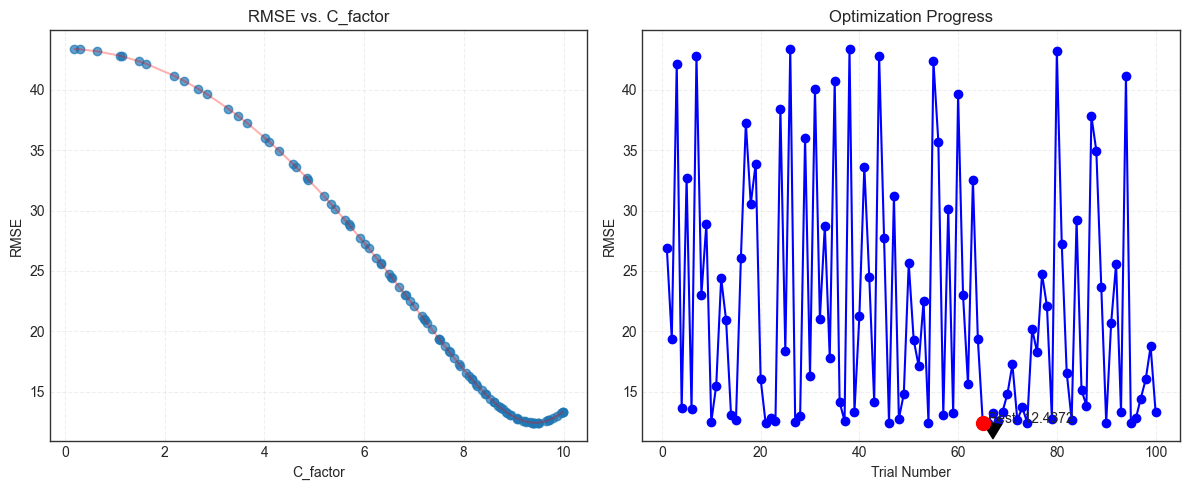


Phase 2: Medium search
100%|██████████| 100/100 [00:01<00:00, 86.27trial/s, best loss: 12.437298798353224]
Optimization Results:
Best C_factor: 9.43636829790995
Best RMSE: 12.437298798353224


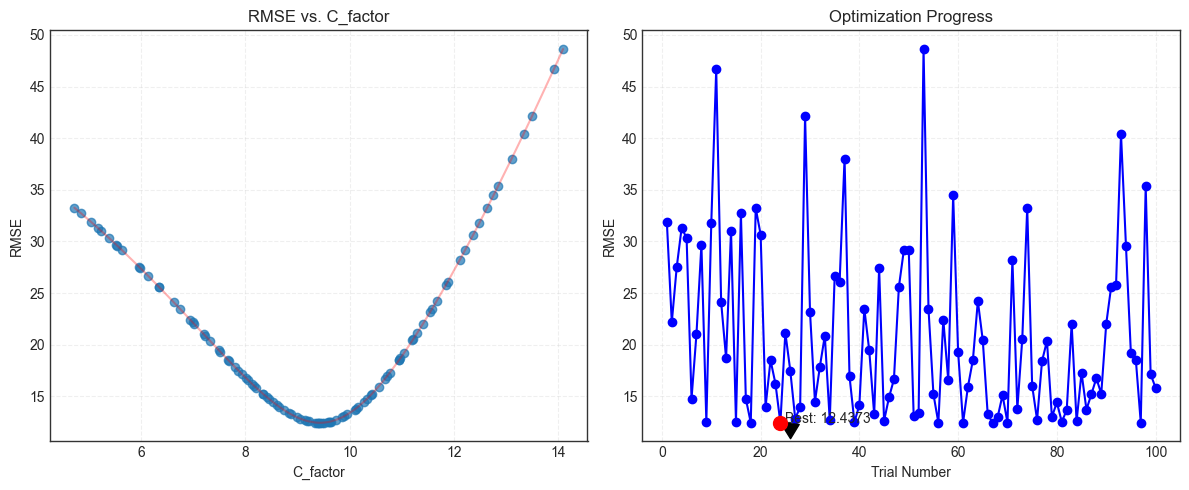


Phase 3: Fine search
100%|██████████| 100/100 [00:00<00:00, 113.36trial/s, best loss: 12.437264359174572]
Optimization Results:
Best C_factor: 9.424336730324097
Best RMSE: 12.437264359174572


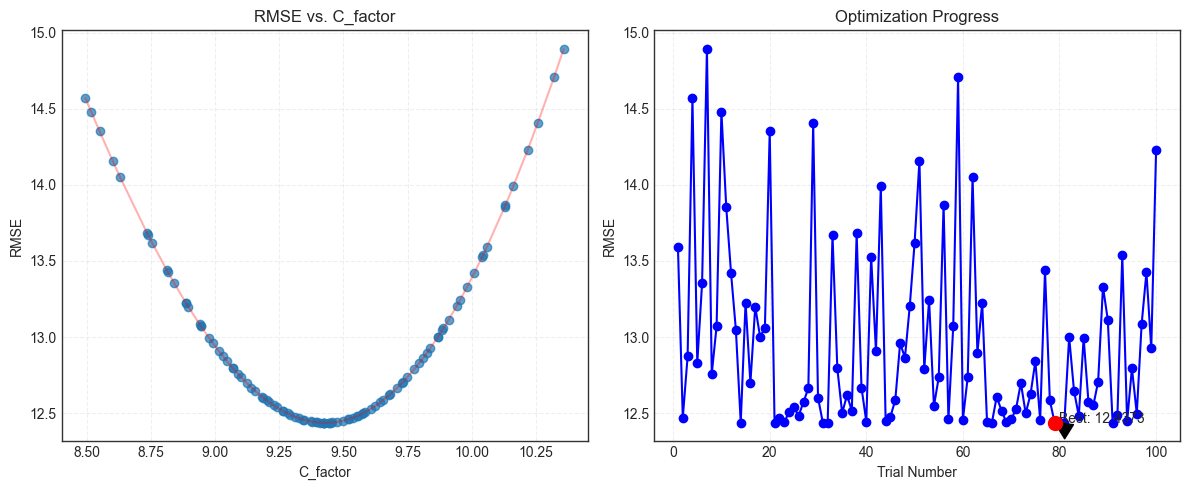


Final Evaluation:
Final optimized C_factor: 9.424336730324097


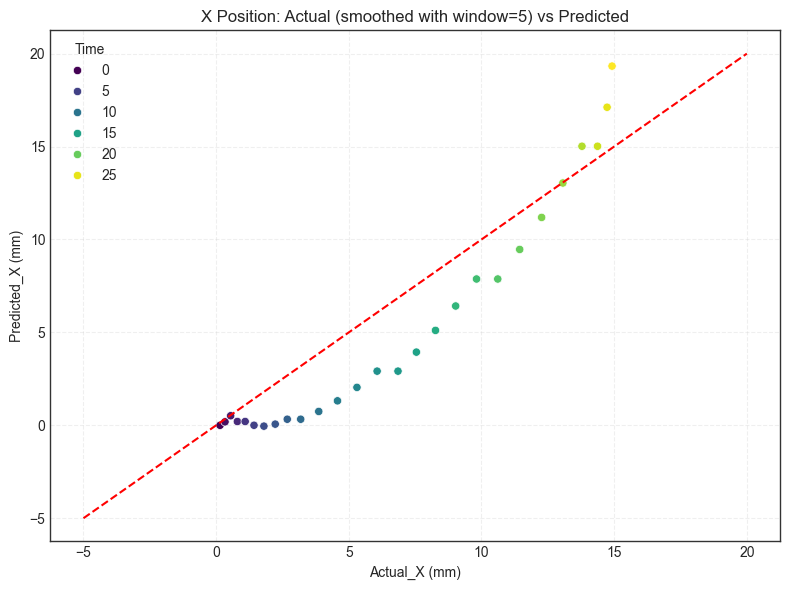

In [444]:
def objective_function(C_factor):
    _, _, pred_positions = get_predicted_results(
        h_WT=2.3e-3,
        L_beam=15e-3,
        C=C_factor,
    )
    _, rmse = pred_vs_actual_plot(
        pred_positions,
        json_file_path = f"../tracked_trajectories/bimorph_idx0_100x_json.csv",
        offset=3,
        show_plot=False,
        max_frame = 30,
    )
    # Return the loss (RMSE) that we want to minimize
    return {"loss": rmse, "status": STATUS_OK, "C_factor": C_factor, "rmse": rmse}

best_c_factor = run_optimization_with_increasing_precision(objective_function)

curvature, radii, pred_positions =  get_predicted_results(
    h_WT=2.3e-3,  # converting mm to m
    L_beam=15e-3,
    C=best_c_factor
)
bimorph_0_x_positions_df, rmse = pred_vs_actual_plot(
    pred_positions,
    json_file_path = f"../tracked_trajectories/bimorph_idx0_100x_json.csv",
    offset=3,
    max_frame = 30,
)

Phase 1: Wide search
100%|██████████| 100/100 [00:00<00:00, 188.53trial/s, best loss: 7.326676771265674]
Optimization Results:
Best C_factor: 5.399934090295655
Best RMSE: 7.326676771265674


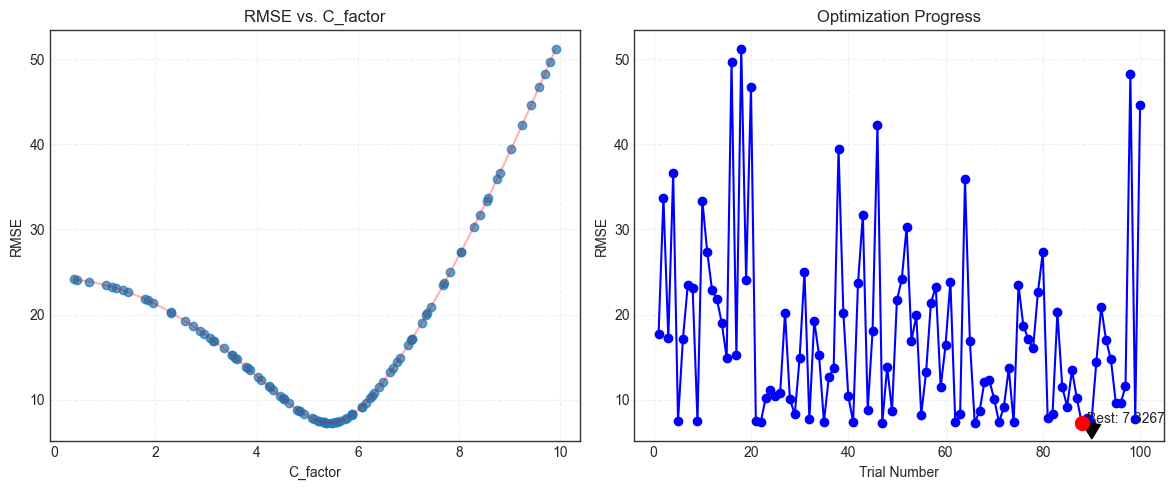


Phase 2: Medium search
100%|██████████| 100/100 [00:00<00:00, 202.28trial/s, best loss: 7.319687956783975]
Optimization Results:
Best C_factor: 5.443004877787356
Best RMSE: 7.319687956783975


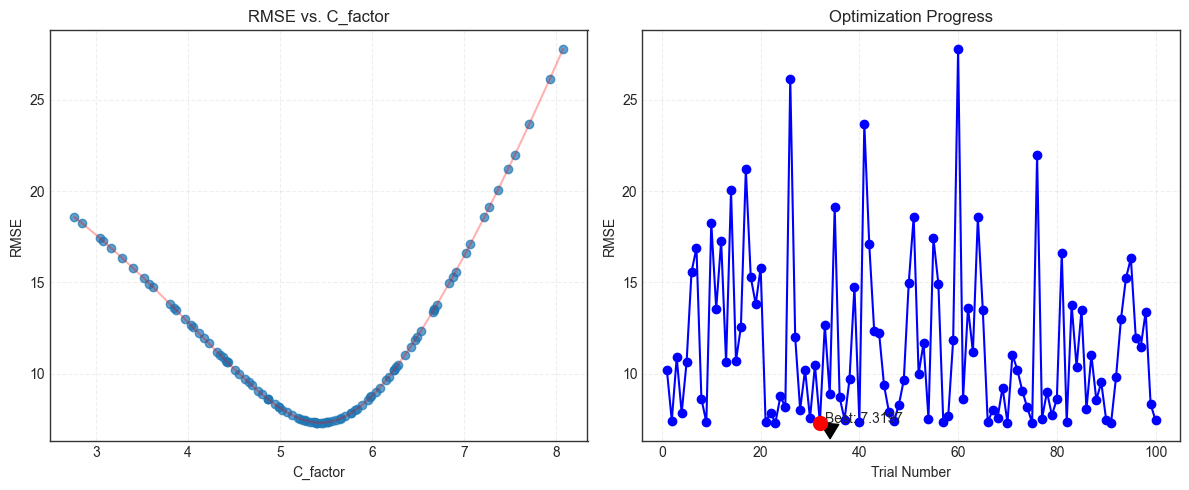


Phase 3: Fine search
100%|██████████| 100/100 [00:00<00:00, 140.39trial/s, best loss: 7.319594771838037]
Optimization Results:
Best C_factor: 5.438315373242495
Best RMSE: 7.319594771838037


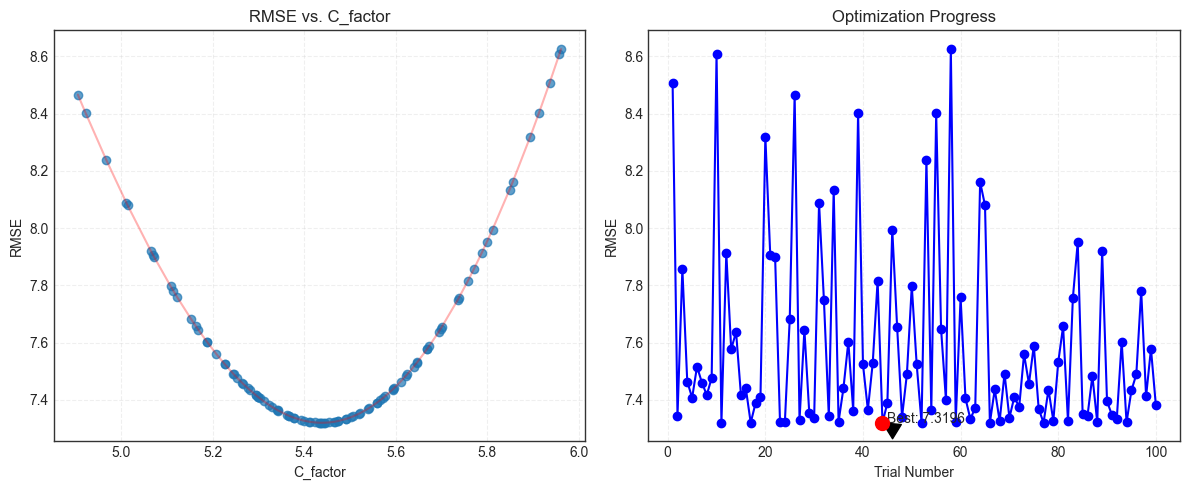


Final Evaluation:
Final optimized C_factor: 5.438315373242495


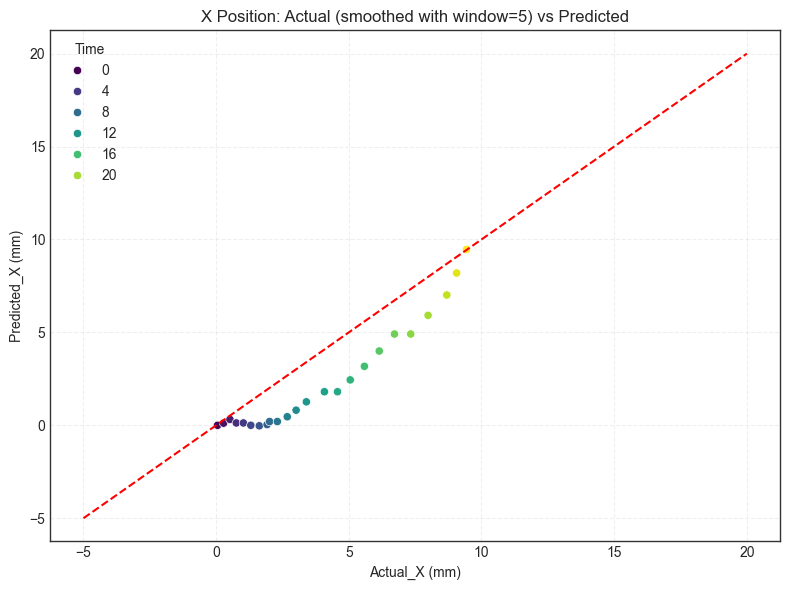

In [445]:
def objective_function(C_factor):
    _, _, pred_positions = get_predicted_results(
        h_WT=2.3e-3,
        L_beam=20e-3,
        C=C_factor,
    )
    
    _, rmse = pred_vs_actual_plot(
        pred_positions,
        json_file_path = f"../tracked_trajectories/bimorph_idx1_100x_json.csv",
        offset=15,
        show_plot=False,
        max_frame = None,
    )
    # Return the loss (RMSE) that we want to minimize
    return {"loss": rmse, "status": STATUS_OK, "C_factor": C_factor, "rmse": rmse}

best_c_factor = run_optimization_with_increasing_precision(objective_function)


curvature, radii, pred_positions =  get_predicted_results(
    h_WT=1.5e-3,  # converting mm to m
    L_beam=20e-3,
    BEAM_SCALE_FACTOR=100000 * 1.2,
    C=1.4
)
# width 2.3
bimorph_1_x_positions_df, rmse = pred_vs_actual_plot(
    pred_positions,
    json_file_path = f"../tracked_trajectories/bimorph_idx1_100x_json.csv",
    offset=15,
    max_frame = None,
)

Phase 1: Wide search
100%|██████████| 100/100 [00:00<00:00, 146.16trial/s, best loss: 16.456639838868877]
Optimization Results:
Best C_factor: 9.99344963516179
Best RMSE: 16.456639838868877


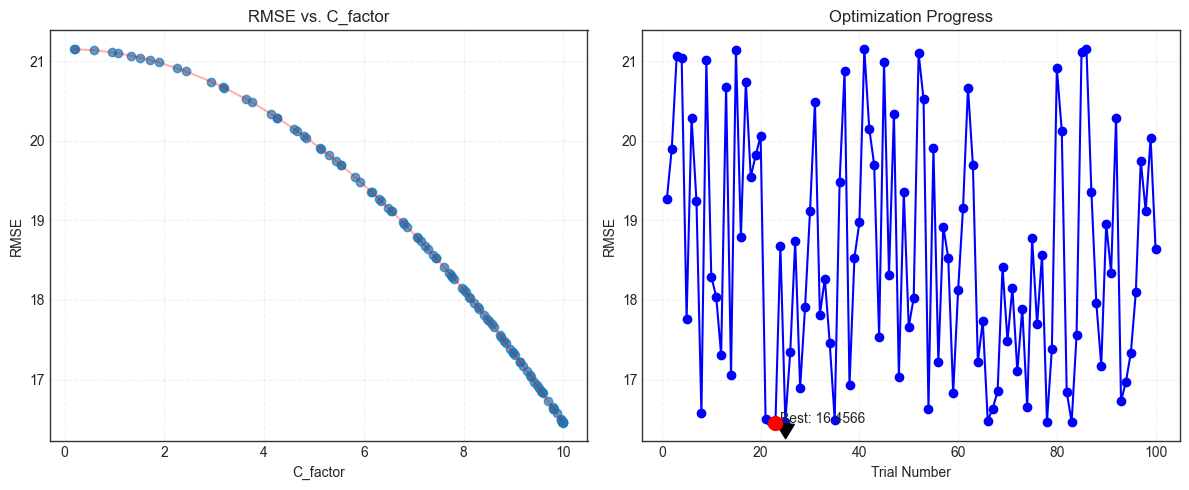


Phase 2: Medium search
100%|██████████| 100/100 [00:00<00:00, 132.86trial/s, best loss: 10.892575019743731]
Optimization Results:
Best C_factor: 14.988953259815835
Best RMSE: 10.892575019743731


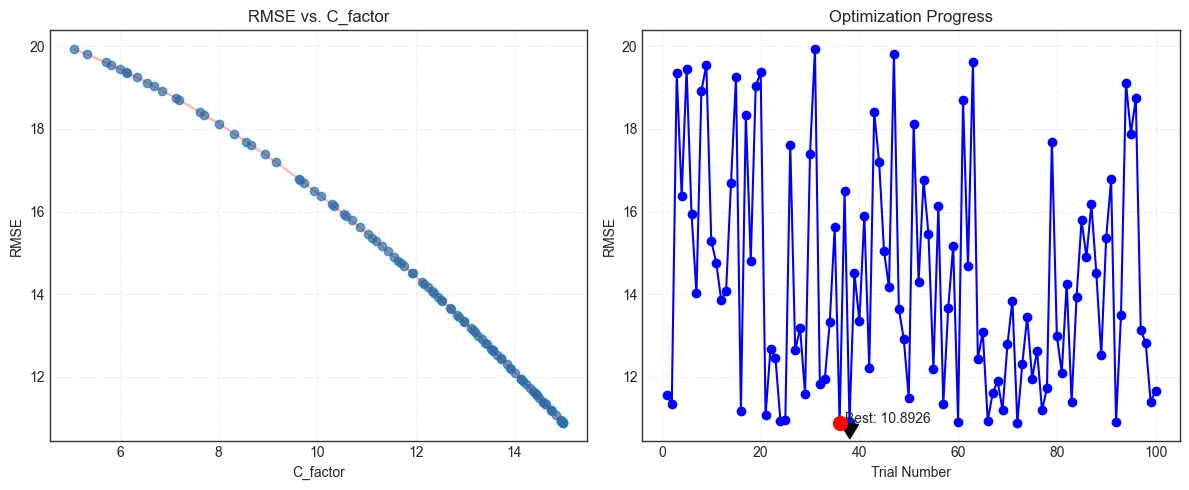


Phase 3: Fine search
100%|██████████| 100/100 [00:01<00:00, 83.16trial/s, best loss: 8.973921942973943]
Optimization Results:
Best C_factor: 16.487421366293262
Best RMSE: 8.973921942973943


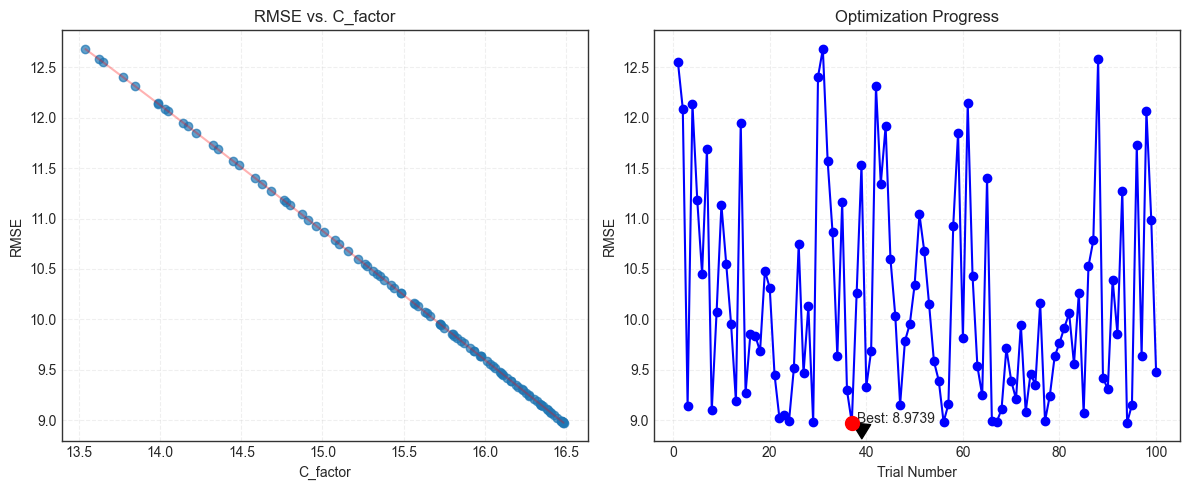


Final Evaluation:
Final optimized C_factor: 16.487421366293262


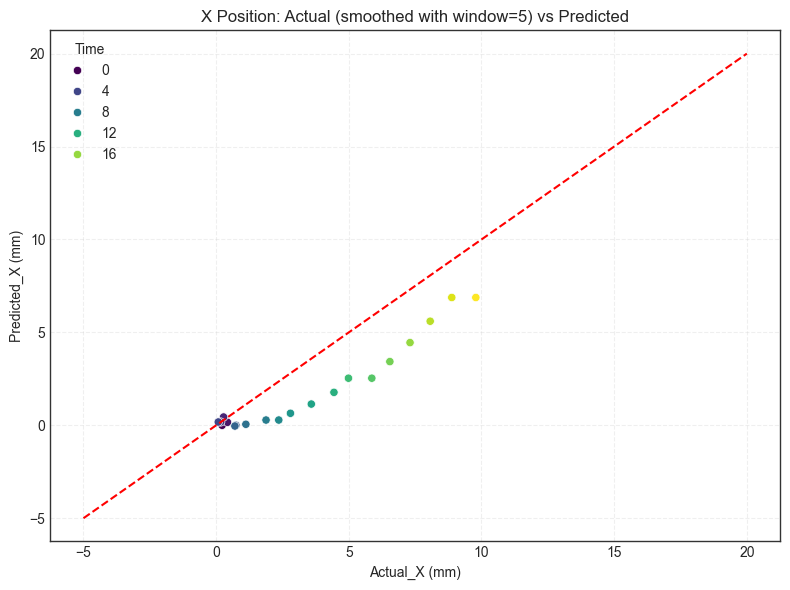

In [446]:
def objective_function(C_factor):
    _, _, pred_positions = get_predicted_results(
        h_WT=3.3e-3,
        L_beam=20e-3,
        C=C_factor,
    )
    _, rmse = pred_vs_actual_plot(
        pred_positions,
        json_file_path = f"../tracked_trajectories/bimorph_idx2_100x_json.csv",
        offset=10,
        show_plot=False,
        max_frame = 30,
    )
    # Return the loss (RMSE) that we want to minimize
    return {"loss": rmse, "status": STATUS_OK, "C_factor": C_factor, "rmse": rmse}

best_c_factor = run_optimization_with_increasing_precision(objective_function)


curvature, radii, pred_positions =  get_predicted_results(
    h_WT=3.3e-3,  # converting mm to m
    L_beam=20e-3,
    BEAM_SCALE_FACTOR=100000 * 1.2,
    C=best_c_factor
)
# width 3.3
bimorph_2_x_positions_df, rmse = pred_vs_actual_plot(
    pred_positions,
    json_file_path = f"../tracked_trajectories/bimorph_idx2_100x_json.csv",
    offset=10,
    max_frame = 30,
)

Phase 1: Wide search
  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 100/100 [00:00<00:00, 139.57trial/s, best loss: 7.002021362212882]
Optimization Results:
Best C_factor: 0.7550911661182536
Best RMSE: 7.002021362212882


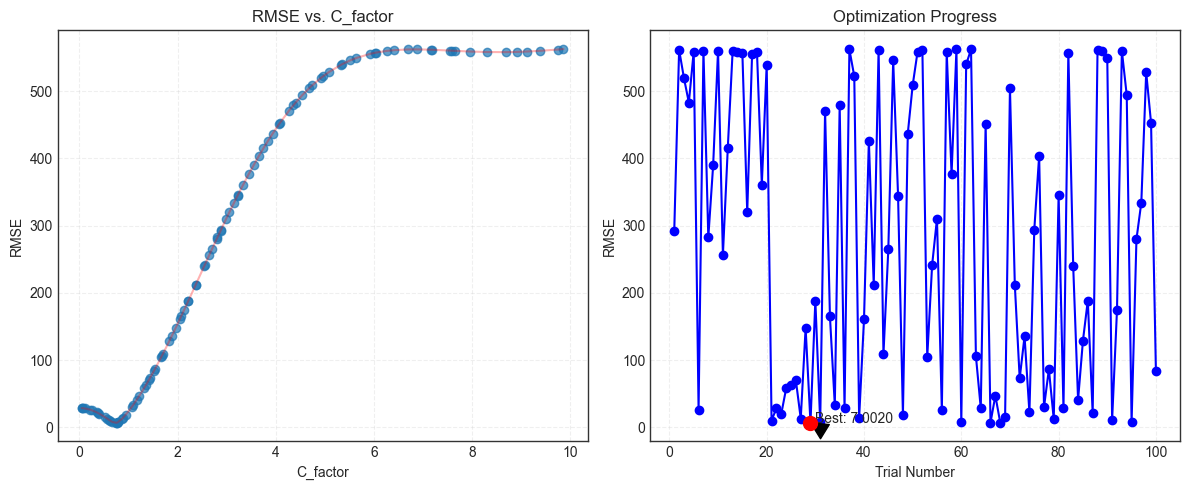


Phase 2: Medium search
100%|██████████| 100/100 [00:00<00:00, 111.13trial/s, best loss: 6.8504627085546534]
Optimization Results:
Best C_factor: 0.7358062936413339
Best RMSE: 6.8504627085546534


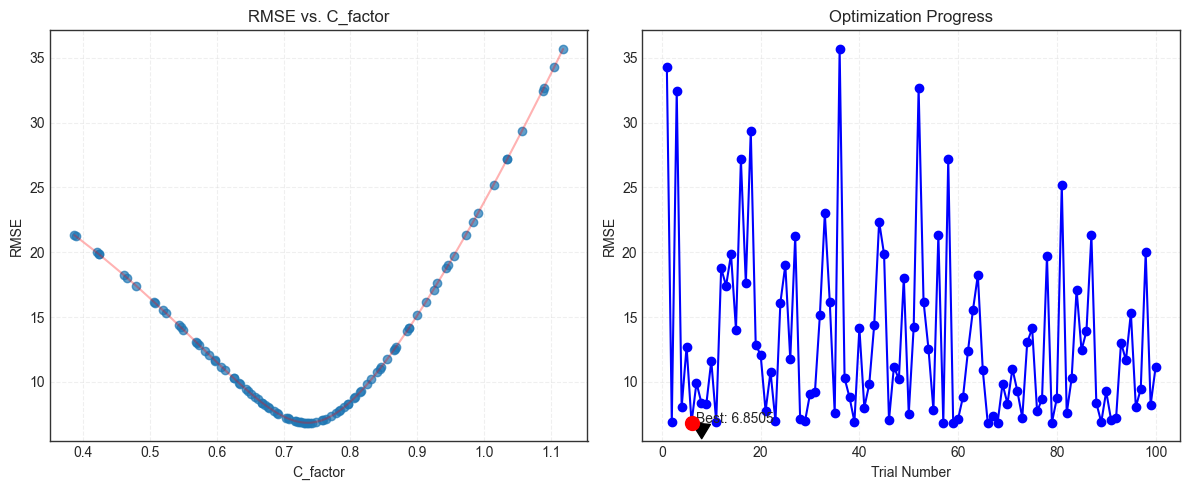


Phase 3: Fine search
100%|██████████| 100/100 [00:00<00:00, 147.46trial/s, best loss: 6.850461793211785]
Optimization Results:
Best C_factor: 0.735999771009834
Best RMSE: 6.850461793211785


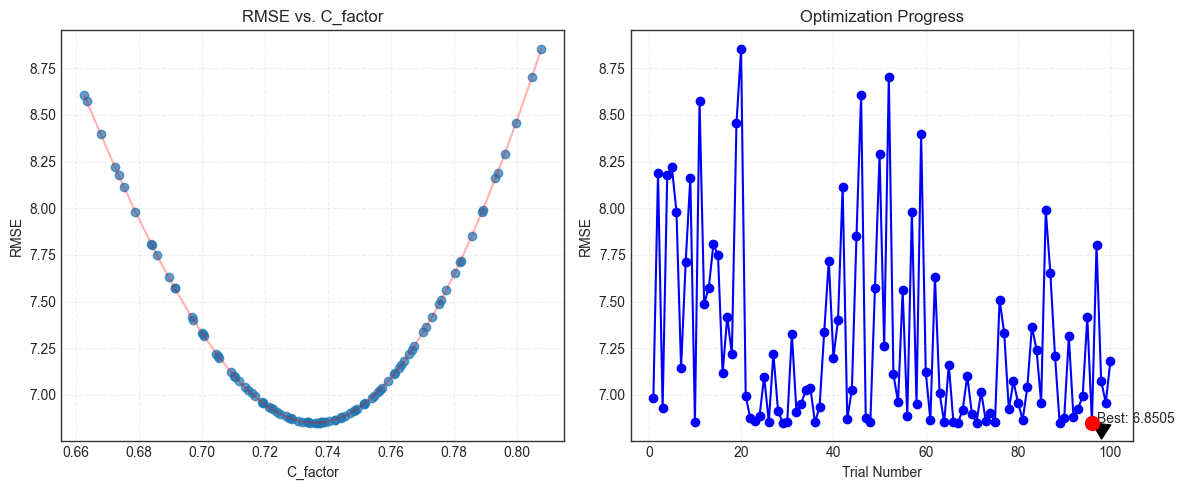


Final Evaluation:
Final optimized C_factor: 0.735999771009834


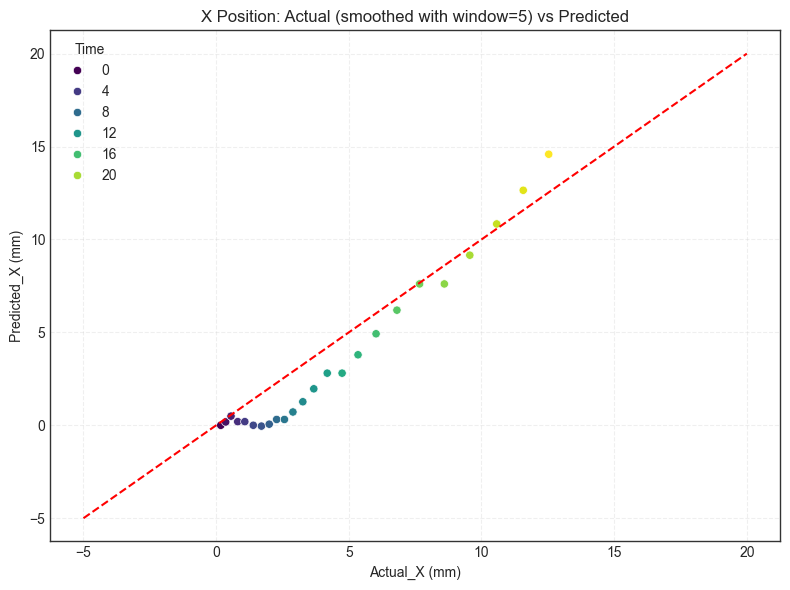

In [447]:
def objective_function(C_factor):
    _, _, pred_positions = get_predicted_results(
        h_WT=1.1e-3,
        L_beam=20e-3,
        C=C_factor,
    )
    _, rmse = pred_vs_actual_plot(
        pred_positions,
        json_file_path = f"../tracked_trajectories/bimorph_idx3_100x_json.csv",
        offset=6,
        max_frame = 30,
        show_plot=False,
    )
    # Return the loss (RMSE) that we want to minimize
    return {"loss": rmse, "status": STATUS_OK, "C_factor": C_factor, "rmse": rmse}

best_c_factor = run_optimization_with_increasing_precision(objective_function)


curvature, radii, pred_positions =  get_predicted_results(
    h_WT=1.1e-3,  # converting mm to m
    L_beam=20e-3,
    BEAM_SCALE_FACTOR=100000 * 1.2,
    C=best_c_factor
)
bimorph_3_x_positions_df, rmse = pred_vs_actual_plot(
    pred_positions,
    json_file_path = f"../tracked_trajectories/bimorph_idx3_100x_json.csv",
    offset=6,
    max_frame = 30,
)

Phase 1: Wide search
100%|██████████| 100/100 [00:00<00:00, 140.08trial/s, best loss: 4.682071577506093]
Optimization Results:
Best C_factor: 0.26458527982327734
Best RMSE: 4.682071577506093


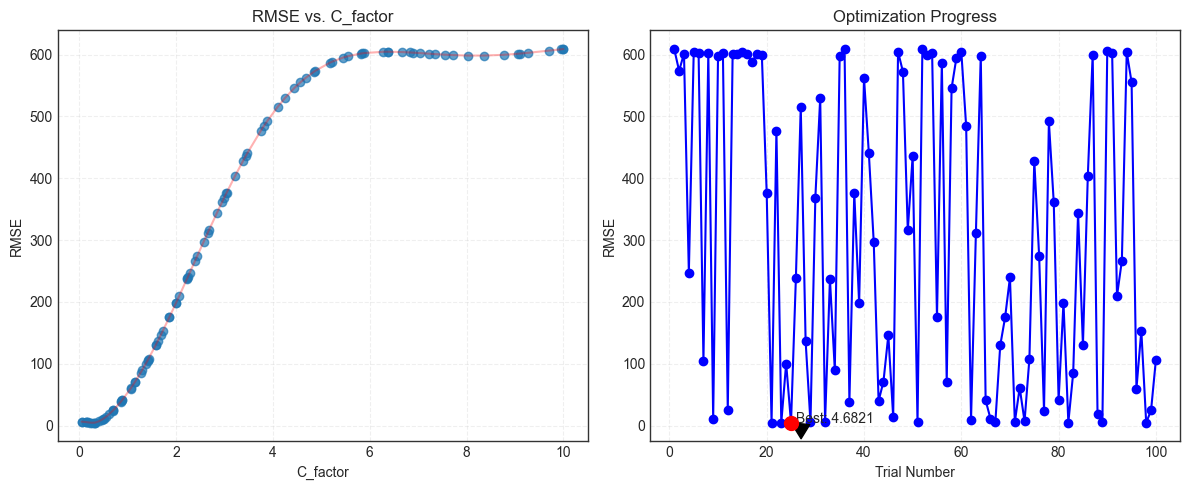


Phase 2: Medium search
100%|██████████| 100/100 [00:00<00:00, 122.39trial/s, best loss: 4.6589557481369575]
Optimization Results:
Best C_factor: 0.2784528249825695
Best RMSE: 4.6589557481369575


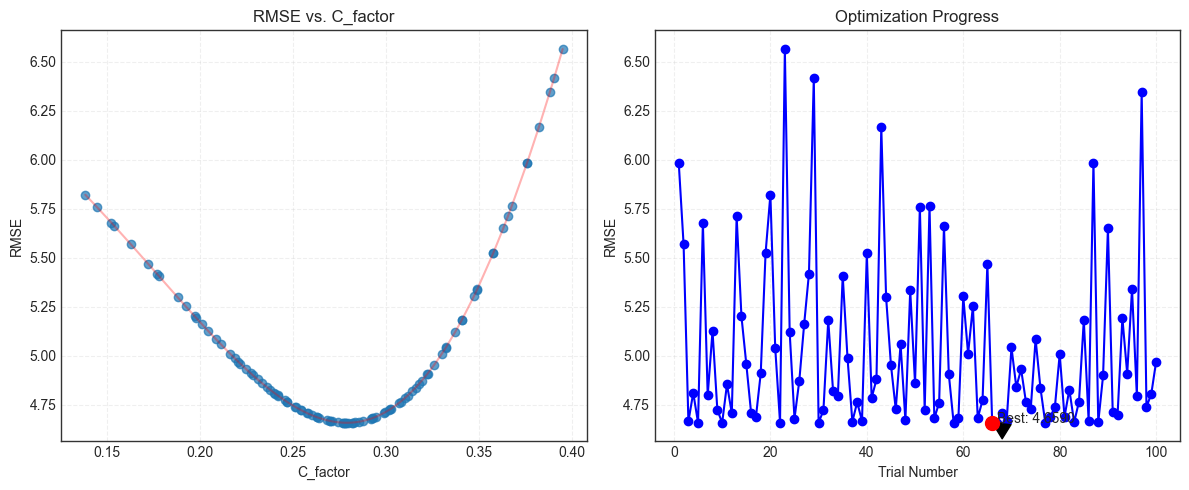


Phase 3: Fine search
100%|██████████| 100/100 [00:00<00:00, 132.71trial/s, best loss: 4.658927038661331]
Optimization Results:
Best C_factor: 0.2788015567510669
Best RMSE: 4.658927038661331


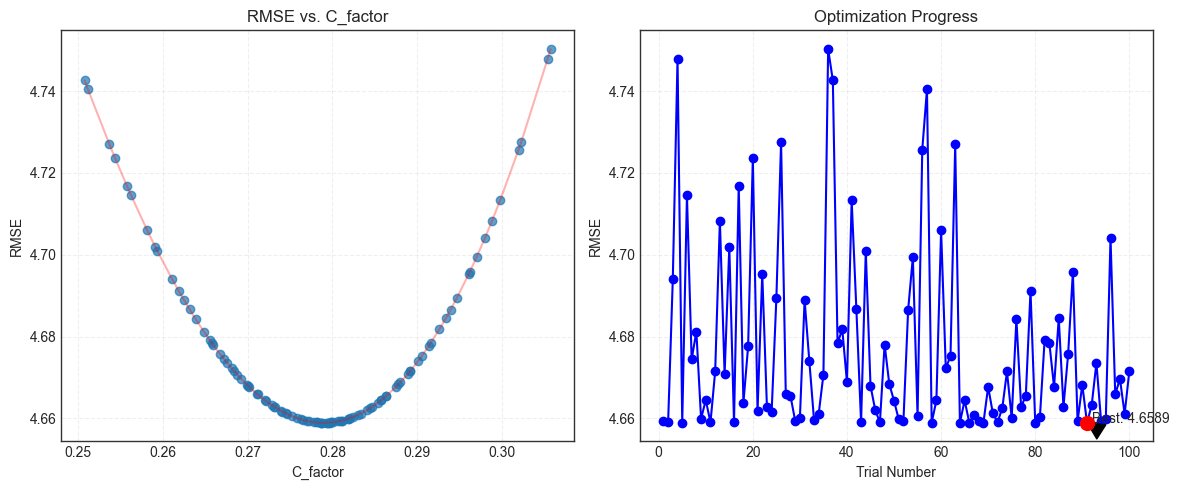


Final Evaluation:
Final optimized C_factor: 0.2788015567510669


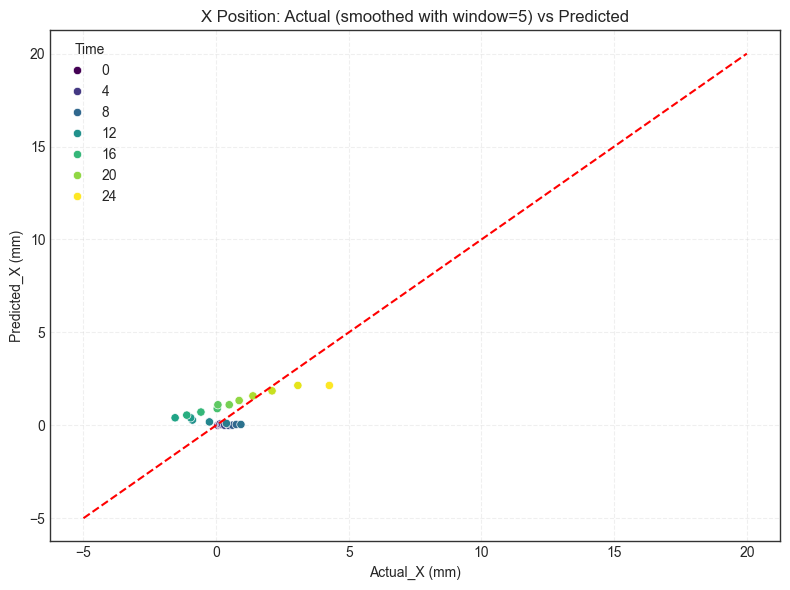

In [448]:
def objective_function(C_factor):
    _, _, pred_positions = get_predicted_results(
        h_WT=1.1e-3,
        L_beam=20e-3,
        C=C_factor,
    )
    _, rmse = pred_vs_actual_plot(
        pred_positions,
        json_file_path = f"../tracked_trajectories/bimorph_idx4_100x_json.csv",
        offset=5,
        max_frame = 30,
        show_plot=False
    )
    # Return the loss (RMSE) that we want to minimize
    return {"loss": rmse, "status": STATUS_OK, "C_factor": C_factor, "rmse": rmse}

best_c_factor = run_optimization_with_increasing_precision(objective_function)

curvature, radii, pred_positions =  get_predicted_results(
    h_WT=1.1e-3,  # converting mm to m
    L_beam=20e-3,
    C=best_c_factor
)
bimorph_4_x_positions_df, rmse = pred_vs_actual_plot(
    pred_positions,
    json_file_path = f"../tracked_trajectories/bimorph_idx4_100x_json.csv",
    offset=5,
    max_frame = 30,
)

Phase 1: Wide search
100%|██████████| 100/100 [00:00<00:00, 154.91trial/s, best loss: 11.694394711904602]
Optimization Results:
Best C_factor: 1.7543356794488039
Best RMSE: 11.694394711904602


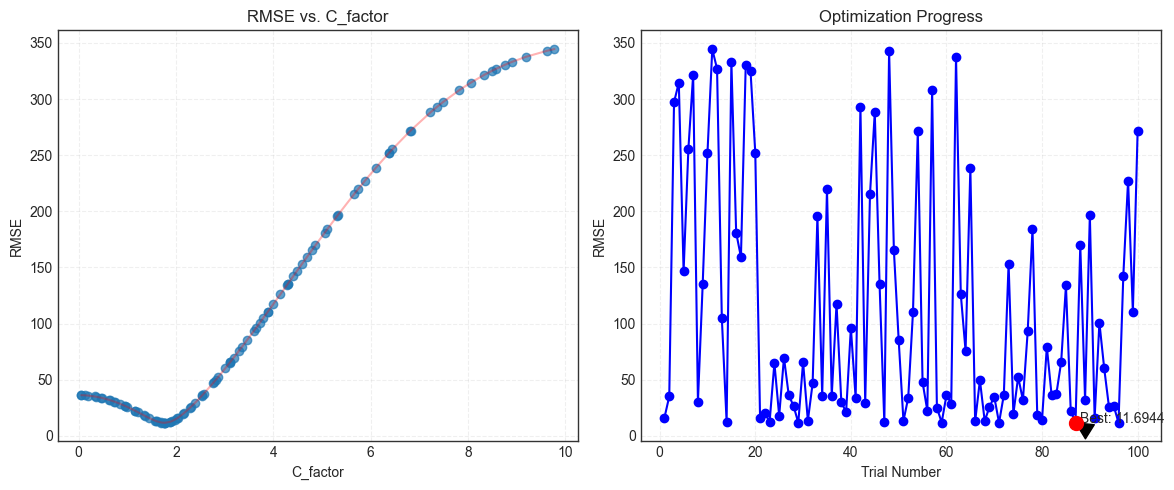


Phase 2: Medium search
100%|██████████| 100/100 [00:00<00:00, 188.83trial/s, best loss: 11.692622278098053]
Optimization Results:
Best C_factor: 1.7631104215929998
Best RMSE: 11.692622278098053


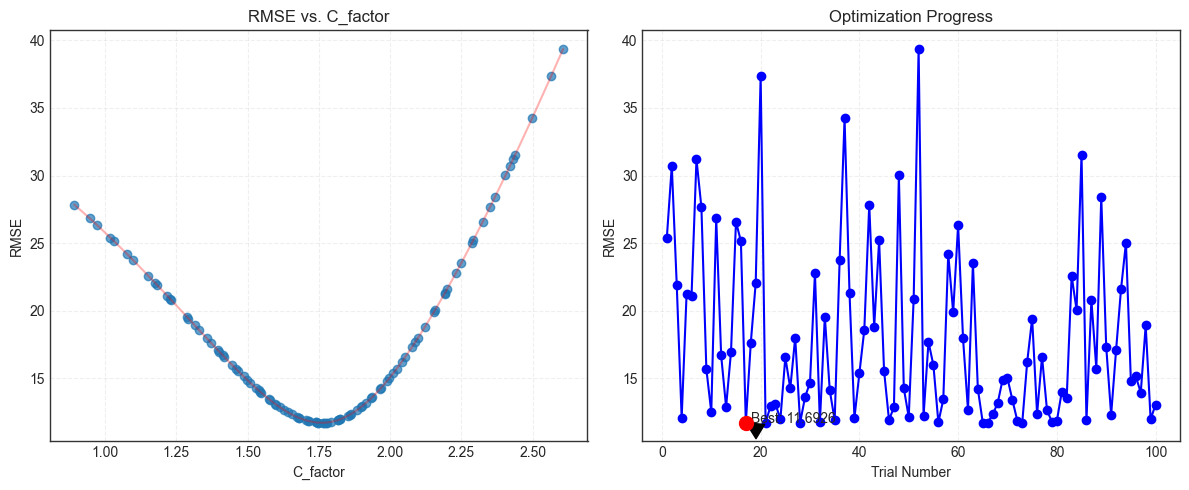


Phase 3: Fine search
100%|██████████| 100/100 [00:00<00:00, 120.08trial/s, best loss: 11.692193470114736]
Optimization Results:
Best C_factor: 1.7599736088584916
Best RMSE: 11.692193470114736


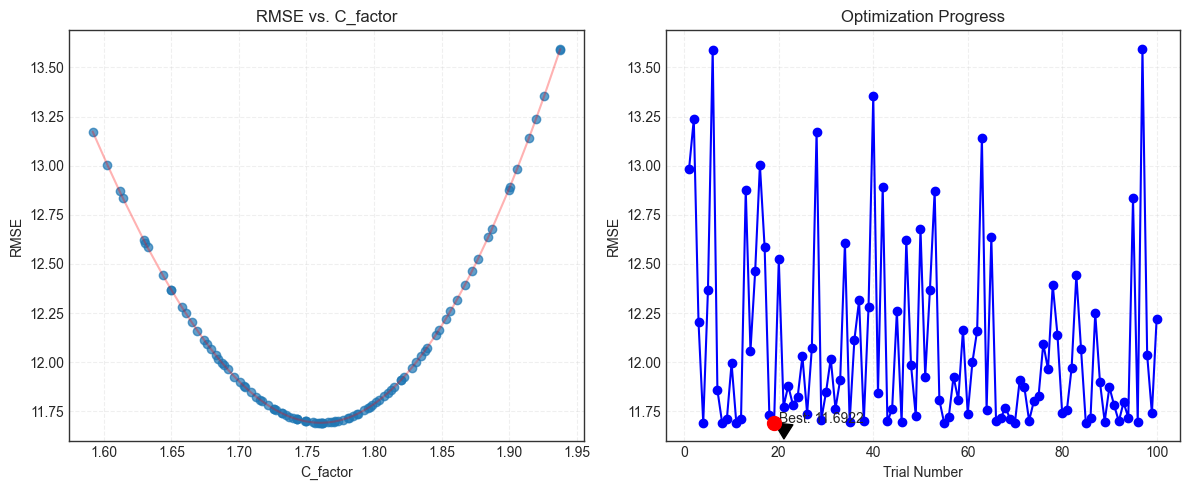


Final Evaluation:
Final optimized C_factor: 1.7599736088584916


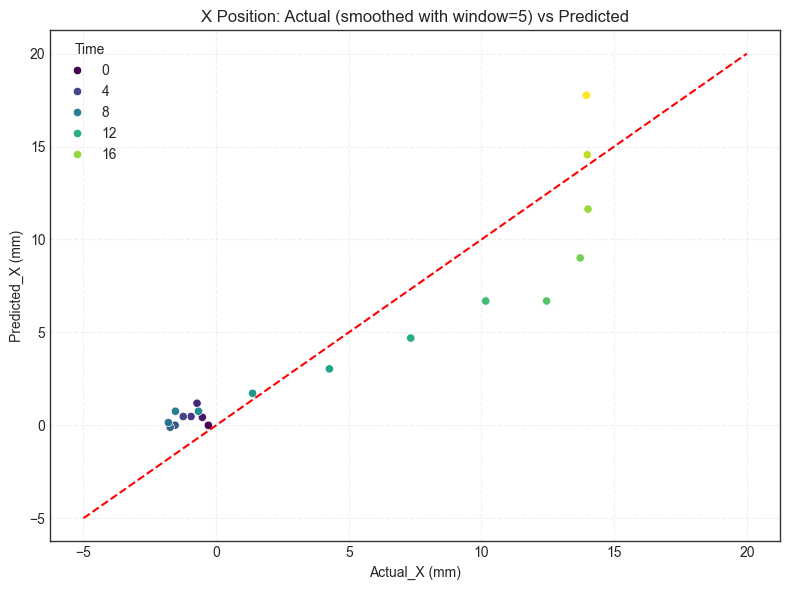

In [449]:
def objective_function(C_factor):
    _, _, pred_positions = get_predicted_results(
        h_WT=1.1e-3,
        L_beam=15e-3,
        C=C_factor,
    )
    _, rmse = pred_vs_actual_plot(
        pred_positions,
        json_file_path=f"../tracked_trajectories/bimorph_idx5_100x_json.csv",
        offset=17,
        show_plot=False,
    )
    # Return the loss (RMSE) that we want to minimize
    return {"loss": rmse, "status": STATUS_OK, "C_factor": C_factor, "rmse": rmse}

best_c_factor = run_optimization_with_increasing_precision(objective_function)

curvature, radii, pred_positions = get_predicted_results(
    h_WT=1.1e-3,  # converting mm to m
    L_beam=15e-3,
    C=best_c_factor,  # this was fit to the data
)
bimorph_5_x_positions_df, rmse = pred_vs_actual_plot(
    pred_positions,
    json_file_path=f"../tracked_trajectories/bimorph_idx5_100x_json.csv",
    offset=17,
)

# NOTE: All h_WT_values copied directly from bimorph_videos/experiments_metadata.csv

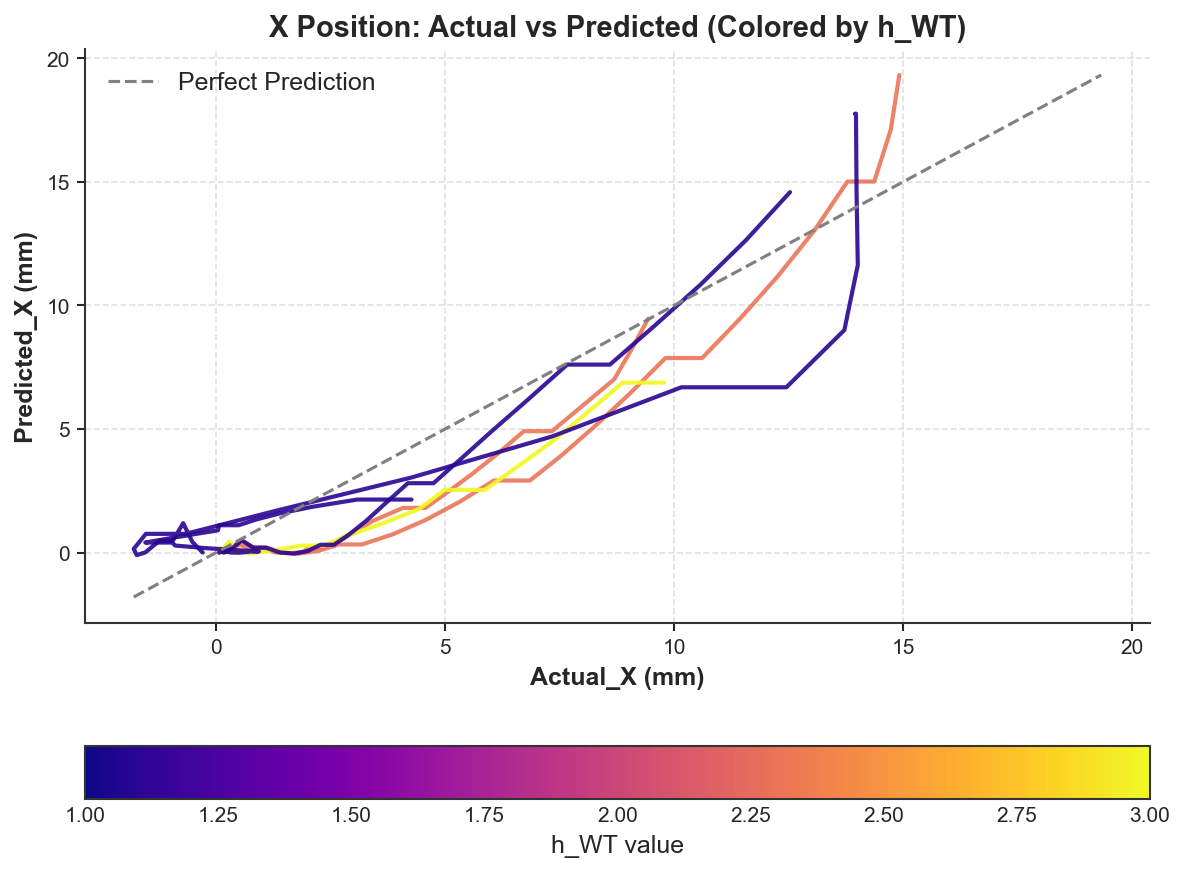

In [450]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import matplotlib as mpl

# Global plot style
plt.style.use('seaborn-v0_8-whitegrid')
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['axes.linewidth'] = 1.0
mpl.rcParams['axes.edgecolor'] = '#333333'
mpl.rcParams['grid.alpha'] = 0.3
mpl.rcParams['grid.linestyle'] = '--'

# Your dataframes and h_WT values
dfs = [
    bimorph_0_x_positions_df,
    bimorph_1_x_positions_df,
    bimorph_2_x_positions_df,
    bimorph_3_x_positions_df,
    bimorph_4_x_positions_df,
    bimorph_5_x_positions_df,
]
h_WT_values = [2.3, 2.3, 3.3, 1.1, 1.1, 1.1]  # Must match length of dfs
cmap = cm.plasma
norm = mcolors.Normalize(vmin=1, vmax=3)

# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 6), dpi=150)

# Plot each trajectory line colored by its corresponding h_WT_value
for df, h_val in zip(dfs, h_WT_values):
    ax.plot(
        df["Actual_X"],
        df["Predicted_X"],
        color=cmap(norm(h_val)),
        linewidth=2,
        alpha=0.9
    )

# Add perfect prediction line (black dashed line)
min_val = min([df["Actual_X"].min() for df in dfs] + [df["Predicted_X"].min() for df in dfs])
max_val = max([df["Actual_X"].max() for df in dfs] + [df["Predicted_X"].max() for df in dfs])
ax.plot([min_val, max_val], [min_val, max_val], color='grey', linestyle='--', label="Perfect Prediction")

# Labels and styling
ax.set_title("X Position: Actual vs Predicted (Colored by h_WT)", fontsize=14, fontweight='bold')
ax.set_xlabel("Actual_X (mm)", fontsize=12, fontweight='bold')
ax.set_ylabel("Predicted_X (mm)", fontsize=12, fontweight='bold')

# Ticks and grid
ax.tick_params(axis='both', which='major', labelsize=10, width=1, length=4)
ax.grid(True, linestyle='--', alpha=0.6)

# Remove top and right spines for a cleaner look
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add colorbar beneath the plot
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Dummy array for colorbar
cbar = fig.colorbar(sm, ax=ax, orientation='horizontal', pad=0.15)
cbar.set_label("h_WT value", fontsize=12)

# Add the legend
ax.legend(fontsize=12, frameon=False)

# Final layout adjustments
plt.tight_layout()

# Show plot
plt.show()

